In [ ]:
import pandas as pd
training_v2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/training_v2.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/unlabeled.csv")


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [ ]:
y = training_v2['hospital_death']
X = training_v2.copy()
X = training_v2.drop('hospital_death',axis = 1)
X1 = training_v2.drop('hospital_death',axis = 1)

In [ ]:
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = X.corr().abs()
corr_matrix.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,...,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
encounter_id,1.000000,0.009575,0.004532,0.003990,0.001068,0.002036,0.005400,0.000992,0.000570,NaN,0.004376,0.006262,0.000113,0.000651,0.001138,0.007920,0.002198,0.002619,0.005435,0.000824,0.003276,0.007664,0.002400,0.006516,0.002108,0.001718,0.001566,0.003172,0.000759,0.015002,0.015002,0.001088,0.005632,0.006498,0.007004,0.005162,0.009225,0.005775,0.009363,0.013306,...,0.000730,0.001471,0.006878,0.005783,0.009662,0.008953,0.003963,0.003424,0.003539,0.005155,0.011436,0.012609,0.002501,0.002825,0.010535,0.011311,0.006958,0.002549,0.003484,0.002009,0.003615,0.001315,0.002119,0.002069,0.000875,0.001810,0.007370,0.005074,0.007282,0.006597,0.000513,0.000344,0.001907,0.007601,0.003402,0.000972,0.001707,0.002172,0.001176,0.004646
patient_id,0.009575,1.000000,0.007075,0.006343,0.001380,0.001387,0.002902,0.001770,0.004412,NaN,0.000275,0.001534,0.001539,0.004215,0.002260,0.003980,0.004292,0.002860,0.004134,0.003811,0.001551,0.002216,0.006673,0.000471,0.000270,0.004735,0.002944,0.001303,0.002413,0.006433,0.006433,0.001393,0.006994,0.000179,0.011433,0.002535,0.006058,0.004433,0.002185,0.003669,...,0.012551,0.012819,0.004313,0.001757,0.011325,0.011179,0.004455,0.004550,0.009513,0.010086,0.000044,0.000180,0.000606,0.000672,0.000999,0.006809,0.000683,0.004415,0.001944,0.003621,0.006064,0.006501,0.003925,0.006113,0.003661,0.003633,0.001242,0.001541,0.000220,0.003382,0.003735,0.001625,0.002426,0.001307,0.000434,0.001667,0.000548,0.000844,0.002333,0.003065
hospital_id,0.004532,0.007075,1.000000,0.008673,0.012874,0.052123,0.027895,0.004526,0.001285,NaN,0.026314,0.011685,0.006806,0.031896,0.053985,0.000844,0.017921,0.014084,0.001126,0.014941,0.011727,0.020512,0.017576,0.002954,0.000057,0.007649,0.002436,0.027670,0.001011,0.020200,0.020200,0.006726,0.013026,0.023262,0.001482,0.033490,0.049851,0.030761,0.006752,0.007217,...,0.021403,0.018969,0.002463,0.007411,0.000334,0.006328,0.032203,0.030355,0.012734,0.023798,0.032732,0.025685,0.012899,0.012030,0.001688,0.016839,0.025894,0.000762,0.018122,0.005636,0.021170,0.014118,0.016317,0.021915,0.016632,0.010328,0.012004,0.029556,0.011965,0.018974,0.006993,0.000283,0.004947,0.002962,0.011978,0.001362,0.000146,0.002992,0.002588,0.004730
age,0.003990,0.006343,0.008673,1.000000,0.087077,0.067320,0.109937,0.024257,0.049872,NaN,0.127252,0.116633,0.022914,0.056060,0.059246,0.001684,0.044981,0.237187,0.056178,0.037935,0.026363,0.025843,0.007754,0.017829,0.007043,0.149495,0.118853,0.015396,0.015870,0.033000,0.033000,0.020300,0.046525,0.037328,0.037734,0.082265,0.176577,0.041296,0.010786,0.190410,...,0.120492,0.123719,0.107346,0.118262,0.007298,0.004765,0.103959,0.104354,0.041772,0.038608,0.029323,0.026215,0.052662,0.051740,0.041012,0.056249,0.047509,0.055960,

In [ ]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
#Drop the columns with high correlations
X = X.drop(columns = to_drop)

There are 59 columns to remove.


In [ ]:
# Train missing values (in percent)
train_missing = (X.isnull().sum() / len(X)).sort_values(ascending = False)
train_missing.head()
train_missing = train_missing.index[train_missing > 0.75]
print('There are %d columns with more than 75%% missing values' % len(train_missing))
X = X.drop(columns = train_missing)

There are 18 columns with more than 75% missing values


In [ ]:
#Convert categorical variable into dummy/indicator variables.
X = pd.get_dummies(X)

In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
  for i in range(2):
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)],eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.343391	valid_0's auc: 0.899394
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.301481	valid_0's auc: 0.895847
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.323438	valid_0's auc: 0.897345


In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

,feature,importance
90,apache_4a_hospital_death_prob,127.5
76,d1_lactate_min,97.0
3,age,93.5
7,icu_id,80.5
38,d1_heartrate_min,80.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()
# Drop features with zero importance
X = X.drop(columns = zero_features)

There are 30 features with 0.0 importance


In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
   # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

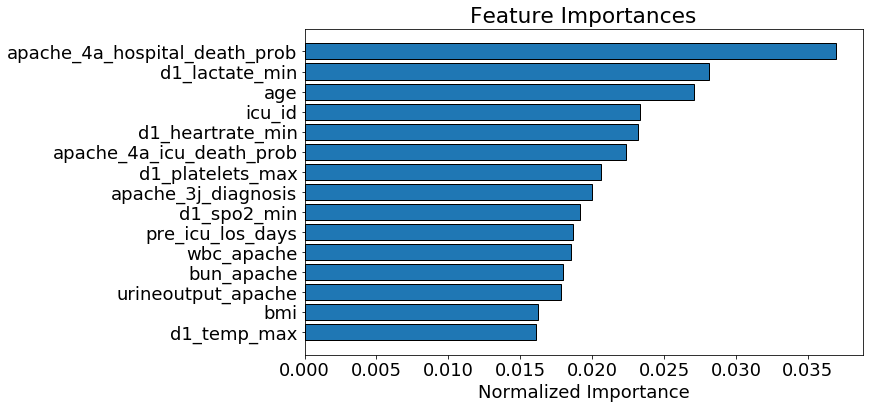

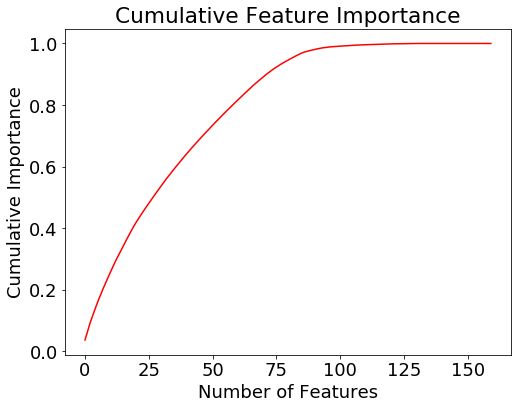

73 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [ ]:
imp_features=list(norm_feature_importances['feature'][0:80])

In [ ]:
imp_features

['apache_4a_hospital_death_prob',
 'd1_lactate_min',
 'age',
 'icu_id',
 'd1_heartrate_min',
 'apache_4a_icu_death_prob',
 'd1_platelets_max',
 'apache_3j_diagnosis',
 'd1_spo2_min',
 'pre_icu_los_days',
 'wbc_apache',
 'bun_apache',
 'urineoutput_apache',
 'bmi',
 'd1_temp_max',
 'creatinine_apache',
 'd1_glucose_min',
 'd1_sysbp_min',
 'd1_hemaglobin_max',
 'd1_resprate_min',
 'glucose_apache',
 'd1_sysbp_max',
 'd1_mbp_min',
 'd1_temp_min',
 'd1_sodium_max',
 'apache_2_diagnosis',
 'hematocrit_apache',
 'temp_apache',
 'd1_heartrate_max',
 'bilirubin_apache',
 'h1_heartrate_max',
 'd1_pao2fio2ratio_max',
 'd1_inr_max',
 'd1_resprate_max',
 'd1_hco3_max',
 'd1_arterial_ph_min',
 'h1_glucose_max',
 'd1_arterial_pco2_max',
 'd1_arterial_po2_min',
 'weight',
 'd1_pao2fio2ratio_min',
 'resprate_apache',
 'h1_resprate_min',
 'map_apache',
 'h1_sysbp_min',
 'hospital_id',
 'd1_diasbp_max',
 'heart_rate_apache',
 'height',
 'd1_hco3_min',
 'd1_arterial_po2_max',
 'h1_temp_max',
 'h1_sysbp_m

In [ ]:
x2=X1[imp_features]
x2.shape

(91713, 80)

In [ ]:
X_train=x2.copy()
Y_train=pd.DataFrame(training_v2['hospital_death'])

In [ ]:
#X_train.shape
Y_train.shape
Y_train

,hospital_death
0,0
1,0
2,0
3,0
4,0
...,...
91708,0
91709,0
91710,0
91711,0


In [ ]:
X_train.shape

(91713, 80)

In [ ]:
X_train.shape

(91713, 80)

In [ ]:
Y_test = pd.DataFrame(test['hospital_death'])
X_test = test.copy()
X_test=X_test[imp_features]


In [ ]:
X_train.shape

(91713, 80)

In [ ]:
Y_train.shape

(91713, 1)

In [ ]:
X_train.to_csv("X_train.csv",index=False)
Y_train.to_csv("Y_train.csv",index=False)
X_test.to_csv("X_test.csv",index=False)
Y_test.to_csv("Y_test.csv",index=False)


In [ ]:
from google.colab import files
files.download('X_train.csv')

In [ ]:
files.download('Y_train.csv')

In [ ]:
files.download('X_test.csv')

In [ ]:
files.download('Y_test.csv')